# AI CA#2
## University of Tehran
#### Simin Eskandari
#### SID:810100240

## Genetic

In [9]:
import random
from PIL import Image, ImageDraw
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import os
OFFSET = 10    

Set a constant OFFSET value of 10, used later to extend the range for generating triangle vertices.

In [10]:
                                                            

def generate_point(width, height):
    x = random.randrange(0 - OFFSET, width + OFFSET, 1)
    y = random.randrange(0 - OFFSET, height + OFFSET, 1)
    return (x, y)

class Triangle:
    def __init__(self, img_width, img_height):
        self.points = [generate_point(img_width, img_height) for _ in range(3)]
        self.color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(50, 150)  # Alpha value for transparency
        )


In [11]:

class Chromosome:  
    def __init__(self, img_height, img_width, target_image, num_triangles):
        self.img_height = img_height
        self.img_width = img_width  
        self.background_color = (0, 0, 0, 255)
        self.triangles = [Triangle(img_width, img_height) for _ in range(num_triangles)]
        self.target_image = np.array(target_image) / 255

    def mutate(self, mutation_rate=0.01):                   #1
        for triangle in self.triangles:                     #2
            if random.random() < mutation_rate:             #3
                if random.random() < 0.5:                   #4
                    triangle.color = (                      #5
                        random.randint(0, 255),             #6
                        random.randint(0, 255),             #7          
                        random.randint(0, 255),             #8
                        random.randint(50, 150)             #9
                )                                           #10
                else:                                       
                    triangle.points = [generate_point(self.img_width, self.img_height) for _ in range(3)]
                                                        
    def draw(self) -> Image:
        # Corrected: Use self.img_width and self.img_height to define the image size
        img = Image.new('RGB', (self.img_width, self.img_height), self.background_color)
        draw = Image.new('RGBA', (self.img_width, self.img_height))
        pdraw = ImageDraw.Draw(draw)
        for triangle in self.triangles:
            pdraw.polygon(triangle.points, fill=triangle.color, outline=triangle.color)
        img.paste(draw, mask=draw)
        return img

    def fitness(self) -> float:
        created_image = np.array(self.draw()) / 255  # Normalize created image
        return np.mean((created_image - self.target_image) ** 2)
    
    


## mutate :
**Line 1**: `def mutate(self, mutation_rate=0.01):`
   - Defines the `mutate` function within the `Chromosome` class, with a default mutation rate of `0.01` (1%).

**Line 2**: `for triangle in self.triangles:`
   - Begins a loop over each `triangle` in the chromosome's list of triangles.

**Line 3**: `if random.random() < mutation_rate:`
   - Generates a random number between 0 and 1 and checks if it is less than the mutation rate. If true, this triangle will undergo mutation.

**Line 4**: `if random.random() < 0.5:`
   - Generates another random number. If it is less than 0.5, the triangle’s color will be mutated; otherwise, its points will be mutated.

**Line 5**: `triangle.color = (`
   - Begins defining a new color for the triangle.

**Lines 6–9**: `random.randint(0, 255), ... random.randint(50, 150)`
   - Sets each color component of the triangle:
      - Red, green, and blue values are assigned random integers between 0 and 255.
      - The alpha value (transparency) is assigned a random integer between 50 and 150.

**Line 10**: `else:  # Mutate points`
   - If the random value from Line 4 is greater than or equal to 0.5, this line executes, meaning the triangle’s points will be mutated instead of its color.

**Line 11**: `triangle.points = [generate_point(self.img_width, self.img_height) for _ in range(3)]`
   - Replaces the triangle’s points with three newly generated points within the image dimensions.

## Fitness :
**Line 1**: `def fitness(self) -> float:`
   - Defines the `fitness` function within the `Chromosome` class, specifying that it returns a `float` value. This function calculates how close the chromosome's generated image is to the target image, with lower fitness values indicating a closer match.

**Line 2**: `generated_image_np = np.array(self.draw())`
   - Calls the `draw()` method to generate an image based on the chromosome's current triangles and then converts this generated image into a NumPy array called `generated_image_np`, making it compatible for pixel-wise calculations with the target image.

**Line 3**: `return np.mean((generated_image_np - self.target_image) ** 2)`
   - Calculates the mean squared error (MSE) between `generated_image_np` and `self.target_image` by:
      - Subtracting `self.target_image` from `generated_image_np`, which gives the pixel-wise differences.
      - Squaring each difference to ensure positive values.
      - Taking the mean of these squared differences, providing an overall measure of similarity.
   - This MSE value is returned as the chromosome's fitness score, where lower values indicate a closer match between the generated and target images.





In [ ]:

class GeneticAlgorithm:
    def __init__(self, max_width, max_height, target_image, population_size, triangles_number):
        self.population_size = population_size
        self.max_width = max_width
        self.max_height = max_height
        self.target_image = np.array(target_image) / 255  # Normalize target image
        self.population = [
            Chromosome(max_height, max_width, target_image, triangles_number) for _ in range(population_size)
        ]
        
    def calc_fitnesses(self):
        return [chromosome.fitness() for chromosome in self.population]
    
    def sort_population(self, fitnesses):
        return [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]
    
    def crossover(self, parent1, parent2):
        child = Chromosome(self.max_height, self.max_width, parent1.target_image, len(parent1.triangles))
        child.triangles = [
            copy.deepcopy(random.choice([triangle1, triangle2])) for triangle1, triangle2 in zip(parent1.triangles, parent2.triangles)
        ]
        return child

    def mutation(self, mutation_rate):
        for chromosome in self.population:
            chromosome.mutate(mutation_rate)
    
    def run(self, n_generations):
        fitness_history_min = []
        fitness_history_mean = []
        fitness_history_max = []
        mutation_rate = 0.05  # Initial mutation rate

        for iteration in range(n_generations):
            fitnesses = self.calc_fitnesses()
            self.population = self.sort_population(fitnesses)
            # best_chromosome = self.get_best_of_population()

            # Track fitness statistics
            min_fitness = min(fitnesses)
            mean_fitness = np.mean(fitnesses)
            max_fitness = max(fitnesses)
            fitness_history_min.append(min_fitness)
            fitness_history_mean.append(mean_fitness)
            fitness_history_max.append(max_fitness)

            # Every 100 generations, log progress
            if iteration % 100 == 0:
                print(f"Generation {iteration}: Min Fitness: {min_fitness}, Mean Fitness: {mean_fitness}, Max Fitness: {max_fitness}")
                best_image = self.get_best_of_population()
                best_image.save(os.path.join("output_pg",f"gen_{iteration}.png"))

            # Elitism: retain the top 10% directly
            new_population = self.population[:self.population_size // 10]
            
            # Fill the rest of the population with children of top-performing individuals
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(self.population[:self.population_size // 2], 2)
                child = self.crossover(parent1, parent2)
                new_population.append(child)

            # Mutate the new population
            self.population = new_population
            self.mutation(mutation_rate)

        best_image = self.get_best_of_population()
        return fitness_history_min, fitness_history_mean, fitness_history_max, best_image

    def get_best_of_population(self):
        best_chromosome = self.sort_population(self.calc_fitnesses())[0]
        return best_chromosome.draw()

def resize(image, max_size):
    new_width = int((max_size / max(image.size[0], image.size[1])) * image.size[0])
    new_height = int((max_size / max(image.size[0], image.size[1])) * image.size[1])
    image = image.resize((new_width, new_height), resample=Image.Resampling.LANCZOS)
    return image

# Parameters for testing
# Provide a specific image path here
target_image_path = r"C:\Users\simin\Desktop\AI\CA2\target_images\target_images\eagle.jpg"
image = Image.open(target_image_path)

image = resize(image, 100)

width, height = image.size
population_size = 100
triangles_number = 50
generations = 10000

# Run the algorithm and capture fitness history
alg = GeneticAlgorithm(width, height, image, population_size, triangles_number)
fitness_min, fitness_mean, fitness_max, best_image = alg.run(generations)

# Save the final best image
best_image.save("best_image_result.png")

# Plotting fitness trends
plt.figure(figsize=(12, 6))
plt.plot(fitness_min, label='Min Fitness')
plt.plot(fitness_mean, label='Mean Fitness')
plt.plot(fitness_max, label='Max Fitness')
plt.xlabel("Generations")
plt.ylabel("Fitness (Lower is Better)")
plt.title("Fitness Progress Over Generations")
plt.legend()
plt.show()


Generation 0: Min Fitness: 0.2418759381589831, Mean Fitness: 0.34566592136668495, Max Fitness: 0.4212508693237643
Generation 100: Min Fitness: 0.0017684231783424403, Mean Fitness: 0.0046607239795106, Max Fitness: 0.042684341298412816
Generation 200: Min Fitness: 0.0013427570592507156, Mean Fitness: 0.0028981527462242575, Max Fitness: 0.0353139188890054
Generation 300: Min Fitness: 0.001008622169406483, Mean Fitness: 0.002404586246936881, Max Fitness: 0.039237212571699306
Generation 400: Min Fitness: 0.000712443155119049, Mean Fitness: 0.0019151329131375267, Max Fitness: 0.01504477454281376
Generation 500: Min Fitness: 0.0005697396883094692, Mean Fitness: 0.0032021579578949827, Max Fitness: 0.039777758360226644
Generation 600: Min Fitness: 0.0004880050019611726, Mean Fitness: 0.002009531454491085, Max Fitness: 0.024548468149390868
Generation 700: Min Fitness: 0.00048769354444094934, Mean Fitness: 0.002143220921246296, Max Fitness: 0.02969890368506286
Generation 800: Min Fitness: 0.00041

## crossover :

1. **Line 1**: `def crossover(self, parent1, parent2):`
   - Defines the `crossover` function within the `GeneticAlgorithm` class. It takes two parent chromosomes (`parent1` and `parent2`) and creates a new child chromosome by combining characteristics from both parents.

2. **Line 2**: `child = Chromosome(self.max_height, self.max_width, parent1.target_image, len(parent1.triangles))`
   - Creates a new `Chromosome` object named `child` with the same dimensions and target image as the parents.
   - The `len(parent1.triangles)` argument ensures that the child chromosome has the same number of triangles as the parents.

3. **Line 3**: `child.triangles = [`
   - Begins constructing the list of triangles for the child by selecting individual triangles from either parent.

4. **Line 4**: `copy.deepcopy(random.choice([triangle1, triangle2])) for triangle1, triangle2 in zip(parent1.triangles, parent2.triangles)`
   - Loops through each pair of corresponding triangles from `parent1` and `parent2` using `zip`.
   - For each pair (`triangle1` from `parent1` and `triangle2` from `parent2`):
      - `random.choice([triangle1, triangle2])` randomly selects one triangle from the pair.
      - `copy.deepcopy(...)` creates an independent copy of the selected triangle to avoid altering the original parent triangle.
   - The result is a new list of triangles where each triangle is randomly selected from either parent.

5. **Line 5**: `return child`
   - Returns the `child` chromosome, which is a new combination of triangles from both parents, making it a genetically mixed offspring of `parent1` and `parent2`.

## mutation :

**Line 1**: `def mutation(self, mutation_rate):`
   - Defines the `mutation` function within the `GeneticAlgorithm` class. It takes `mutation_rate` as a parameter, which determines the likelihood of mutation occurring within each chromosome.

**Line 2**: `for chromosome in self.population:`
   - Begins a loop that iterates over each `chromosome` in the population of chromosomes (solutions).

**Line 3**: `chromosome.mutate(mutation_rate)`
   - Calls the `mutate` function on each `chromosome`, passing `mutation_rate` to it.
   - The `mutate` function within each `Chromosome` object will then decide if any of its triangles should undergo random changes based on the provided mutation rate.
  

## run :
**Lines 9–13**: Tracks fitness statistics for each generation:
   - `min_fitness`: Minimum fitness score in the population.
   - `mean_fitness`: Average fitness score of the population.
   - `max_fitness`: Maximum fitness score in the population.
   - These values are appended to the corresponding history lists for tracking.

**Lines 14–16**: Logs and saves every 100th generation:
   - Every 100 generations, prints the minimum, mean, and maximum fitness values.
   - Calls `get_best_of_population()` to retrieve the current best image and saves it to the output folder.

**Line 17**: `new_population = self.population[:self.population_size // 10]`
   - Implements elitism by retaining the top 10% of the population unchanged.

**Lines 18–22**: Fills the rest of the population with children:
    - Randomly selects two parents from the top 50% of the population.
    - Calls `crossover` to produce a child and appends the child to `new_population`.

**Line 23**: `self.mutation(mutation_rate)`
    - Calls `mutation()` on the new population, introducing variations based on the mutation rate.

**Line 24**: `best_image = self.get_best_of_population()`
    - Retrieves the best image of the final generation.

**Line 25**: `return fitness_history_min, fitness_history_mean, fitness_history_max, best_image`
    - Returns the fitness histories and the best image from the final generation.

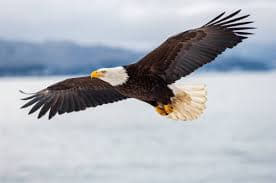
## FINALLY:
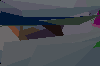
## PROCCESS:
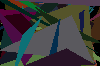
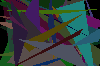

### 1. Calculate the state space for the chromosome considered.
The state space of a chromosome represents all possible configurations it can take. In this code, each chromosome is defined by a set of triangles, each with:
   - Three vertices, each with `x` and `y` coordinates within the dimensions of the target image (width and height).
   - A color with four channels (red, green, blue, and alpha for transparency).

For each triangle:
   - Each vertex has two possible values (x, y), constrained by the image size, and three vertices mean \( \text{img\_width}^3 \times \text{img\_height}^3 \).
   - The color component has 256 possible values per channel (0-255), with a restricted alpha (e.g., 50-150), which gives a certain range of configurations.
   
Therefore, the total state space size for each chromosome can be calculated as:
\[
(\text{possible positions for each vertex})^3 \times (\text{possible color combinations})^{\text{num\_triangles}}
\]
This results in an immense state space, especially as the number of triangles increases.

### 2. Explain two ideas that could make this algorithm converge faster.
   - **Adaptive Mutation Rate**: Instead of a fixed mutation rate, use an adaptive rate that decreases as fitness improves or as the population converges. High mutation rates at the beginning promote exploration, while lower rates later help fine-tune near-optimal solutions.
   - **Elitism and Diversity Promotion**: Retaining a portion of the best individuals (elitism) ensures the highest fitness in each generation. Additionally, using mechanisms like crowding or diversity-based selection ensures that individuals do not converge too quickly, maintaining diversity and preventing premature convergence.

### 3. Describe two strategies for selecting the next generation in genetic algorithms.
   - **Roulette Wheel Selection**: In this strategy, chromosomes are selected based on a probability proportional to their fitness. Higher fitness individuals have a higher chance of being chosen, similar to spinning a weighted wheel where sections are sized by fitness. This helps maintain a balance between exploration and exploitation.
   - **Tournament Selection**: A small, random subset of the population is selected, and the fittest individual from this subset is chosen for reproduction. This is repeated to fill the new population. Tournament selection is efficient and helps prevent premature convergence by maintaining a more diverse gene pool, as only a subset is evaluated each time.

## Game

In [ ]:
import numpy as np
import random
import pygame
import math
from time import sleep, time

ROW_COUNT = 6
COLUMN_COUNT = 7
SQUARESIZE = 100
RADIUS = int(SQUARESIZE / 2 - 5)
PLAYER = 1
CPU = -1
EMPTY = 0
PLAYER_PIECE = 1
CPU_PIECE = -1
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
YELLOW = (255, 255, 0)
WINDOW_LENGTH = 4
WINING_SCORE = 10000000000000

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
class Connect4UI:
    def __init__(self, width=COLUMN_COUNT*SQUARESIZE, height=(ROW_COUNT+1)*SQUARESIZE):
        pygame.init()
        self.width = width
        self.height = height
        self.size = (self.width, self.height)
        self.screen = pygame.display.set_mode(self.size)
        self.font = pygame.font.SysFont("monospace", 75)

    def draw_board(self, board):
        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT):
                pygame.draw.rect(self.screen, BLUE, (c * SQUARESIZE, r * SQUARESIZE + SQUARESIZE, SQUARESIZE, SQUARESIZE))
                pygame.draw.circle(self.screen, BLACK, (int(c * SQUARESIZE + SQUARESIZE / 2), int(r * SQUARESIZE + SQUARESIZE + SQUARESIZE / 2)), RADIUS)

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT):
                if board[r][c] == PLAYER_PIECE:
                    pygame.draw.circle(self.screen, RED, (int(c * SQUARESIZE + SQUARESIZE / 2), self.height - int(r * SQUARESIZE + SQUARESIZE / 2)), RADIUS)
                elif board[r][c] == CPU_PIECE:
                    pygame.draw.circle(self.screen, YELLOW, (int(c * SQUARESIZE + SQUARESIZE / 2), self.height - int(r * SQUARESIZE + SQUARESIZE / 2)), RADIUS)

        pygame.display.update()
        sleep(0.2)
        

    def display_winner(self, winner):
        if winner == PLAYER:
            label = self.font.render("Player wins!!", 1, RED)
        elif winner == CPU:
            label = self.font.render("Computer wins!!", 1, YELLOW)
        else:
            label = self.font.render("It's a draw!!", 1, BLUE)
        self.screen.blit(label, (40, 10))
        pygame.display.update()
        sleep(5)

In [ ]:
class Connect4Game:
    def __init__(self, ui, minimax_depth=1, prune=True):
        self.board = np.zeros((ROW_COUNT, COLUMN_COUNT))
        self.ui = Connect4UI() if ui else None
        self.minimax_depth = minimax_depth
        self.prune = prune
        self.current_turn = random.choice([1, -1])
        
    def drop_piece(self, board, row, col, piece):
        board[row][col] = piece

    def get_next_open_row(self, board,col):
        for r in range(ROW_COUNT):
            if board[r][col] == 0:
                return r

    def print_board(self, board):
        print(np.flip(board, 0))

    def winning_move(self, board, piece):
        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT):
                if all(board[r][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT - 3):
                if all(board[r+i][c] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT - 3):
                if all(board[r+i][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(3, ROW_COUNT):
                if all(board[r-i][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        return False
    
    def evaluate_window(self, window, piece):
        score = 0
        opp_piece = PLAYER_PIECE
        if piece == PLAYER_PIECE:
            opp_piece = CPU_PIECE
        
        if window.count(piece) == 4:
            score += 100
        elif window.count(piece) == 3 and window.count(EMPTY) == 1:
            score += 5
        elif window.count(piece) == 2 and window.count(EMPTY) == 2:
            score += 2
        if window.count(opp_piece) == 3 and window.count(EMPTY) == 1:
            score -= 4
        
        return score
    
    def score_position(self, board, piece):
        score = 0  
        center_array = [int(i) for i in list(board[:, COLUMN_COUNT//2])]
        center_count = center_array.count(piece)
        score += center_count * 3
    
        for r in range(ROW_COUNT):
            row_array = [int(i) for i in list(board[r,:])]
            for c in range(COLUMN_COUNT-3):
                window = row_array[c:c+WINDOW_LENGTH]
                score += self.evaluate_window(window, piece)

        for c in range(COLUMN_COUNT):
            col_array = [int(i) for i in list(board[:,c])]
            for r in range(ROW_COUNT-3):
                window = col_array[r:r+WINDOW_LENGTH]
                score += self.evaluate_window(window, piece)

        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+i][c+i] for i in range(WINDOW_LENGTH)]
                score += self.evaluate_window(window, piece)
                
        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+3-i][c+i] for i in range(WINDOW_LENGTH)]
                score += self.evaluate_window(window, piece)
    
        return score
    
    def is_terminal_node(self, board):
        return self.winning_move(board, PLAYER_PIECE) or self.winning_move(board, CPU_PIECE) or len(self.get_valid_locations(board)) == 0
    
    def get_valid_locations(self, board):
        valid_locations = []
        for col in range(COLUMN_COUNT):
            if board[ROW_COUNT-1][col] == 0:
                valid_locations.append(col)
        return valid_locations
    
    def best_cpu_score(self, board, moves):
        move = None
        max_score = -math.inf
        for col in moves:
            row = self.get_next_open_row(board, col)
            b_copy = board.copy()
            self.drop_piece(b_copy, row, col, CPU_PIECE)
            score = self.heuristic(b_copy, CPU_PIECE)
            if score > max_score:
                max_score = score
                move = col
        return move
    
    def heuristic(self, board, piece):
        if(self.is_terminal_node(board)):
            if self.winning_move(board, piece):
                return WINING_SCORE
            elif self.winning_move(board, -piece):
                return -WINING_SCORE
            else:
                return 0
        else:
            return self.score_position(board, piece) - self.score_position(board, -piece)
        
    # TODO:
    
    def minimax(self, board, depth, alpha, beta, player):
        # Check for terminal state or max depth
        valid_locations = self.get_valid_locations(board)
        is_terminal = self.is_terminal_node(board)
        if depth == 0 or is_terminal:
            if is_terminal:
                if self.winning_move(board, CPU_PIECE):
                    return (None, WINING_SCORE)
                elif self.winning_move(board, PLAYER_PIECE):
                    return (None, -WINING_SCORE)
                else:  # No valid moves - tie game
                    return (None, 0)
            else:  # Depth is zero
                return (None, self.heuristic(board, CPU_PIECE if player == CPU else PLAYER_PIECE))
        
        if player == CPU:
            max_eval = -math.inf
            best_col = random.choice(valid_locations)
            for col in valid_locations:
                row = self.get_next_open_row(board, col)
                b_copy = board.copy()
                self.drop_piece(b_copy, row, col, CPU_PIECE)
                new_score = self.minimax(b_copy, depth - 1, alpha, beta, PLAYER)[1]
                if new_score > max_eval:
                    max_eval = new_score
                    best_col = col
                if self.prune:
                    alpha = max(alpha, max_eval)
                    if alpha >= beta:
                        break
            return best_col, max_eval

        else:  # Player's turn, minimizing player
            min_eval = math.inf
            best_col = random.choice(valid_locations)
            for col in valid_locations:
                row = self.get_next_open_row(board, col)
                b_copy = board.copy()
                self.drop_piece(b_copy, row, col, PLAYER_PIECE)
                new_score = self.minimax(b_copy, depth - 1, alpha, beta, CPU)[1]
                if new_score < min_eval:
                    min_eval = new_score
                    best_col = col
                if self.prune:
                    beta = min(beta, min_eval)
                    if alpha >= beta:
                        break
            return best_col, min_eval
       
        
    def get_cpu_move(self, board, randomness_percent=30):
        moves = self.get_valid_locations(board)
        if len(moves) == 0:
            return None
        random_move = random.choice(moves)
        score_move = self.best_cpu_score(board, moves)
        move = random.choice([score_move] * (100 - randomness_percent) + [random_move] * randomness_percent)
        return move, self.get_next_open_row(board, move)


    def get_human_move(self, board, depth = 1):
        col = self.minimax(board, depth, -math.inf, math.inf, self.current_turn)[0]
        return col, self.get_next_open_row(board, col)

    def play(self):
        winner = None
        while not self.is_terminal_node(self.board):
            if self.ui:
                self.ui.draw_board(self.board)
            if self.current_turn == PLAYER:
                col, row = self.get_human_move(self.board, self.minimax_depth)
                if col is not None:
                    self.drop_piece(self.board, row, col, PLAYER_PIECE)
                    if self.winning_move(self.board, PLAYER_PIECE):
                        winner = PLAYER
                    self.current_turn = CPU
            else:
                col, row = self.get_cpu_move(self.board)
                if col is not None:
                    self.drop_piece(self.board, row, col, CPU_PIECE)
                    if self.winning_move(self.board, CPU_PIECE):
                        winner = CPU
                    self.current_turn = PLAYER
            
            if self.ui:
                self.ui.draw_board(self.board)
                if winner is not None:
                    self.ui.display_winner(winner)
                            
        if winner is None:
            winner = 0
        return winner

Complete the Connect4Game class below by implementing the `minimax algorithm` with `alpha-beta pruning` and `depth limiting`. Don't change other parts of the code unless you want to define a new heuristic function.

In [ ]:
def print_results(results, depth, pruning, start, end):
    pruning_status = "Enabled" if pruning else "Disabled"
    print(
        f'Depth: {depth} | Pruning: {pruning_status} -> User Wins: {results[1]:3}, CPU Wins: {results[-1]:2}, Ties: {results[0]:2}, Time: {end - start:.2f}s'
    )

Use the code below to test the game with the UI. Pygame is not compatible with Jupyter Notebook and will not work in this environment. To use Pygame, please run the code in a separate `.py` file.

In [ ]:
# game = Connect4Game(True, 3, True)
# game.play()

Run the following code to test the results of the game and the time taken to play the game in different `depths` and with `pruning` enabled and disabled.

In [ ]:
def check_results():
    for pruning in [True, False]:  
        for d in range(1, 4):
            results = {-1: 0, 0: 0, 1: 0}
            start = time()
            for _ in range(20):  
                game = Connect4Game(False, d, pruning)  
                results[game.play()] += 1
            end = time()
            print_results(results, d, pruning, start, end)

check_results()

Depth: 1 | Pruning: Enabled -> User Wins:  11, CPU Wins:  9, Ties:  0, Time: 0.21s
Depth: 2 | Pruning: Enabled -> User Wins:  12, CPU Wins:  8, Ties:  0, Time: 0.20s
Depth: 3 | Pruning: Enabled -> User Wins:  12, CPU Wins:  8, Ties:  0, Time: 0.20s
Depth: 1 | Pruning: Disabled -> User Wins:   9, CPU Wins: 11, Ties:  0, Time: 0.20s
Depth: 2 | Pruning: Disabled -> User Wins:   6, CPU Wins: 14, Ties:  0, Time: 0.22s
Depth: 3 | Pruning: Disabled -> User Wins:  12, CPU Wins:  8, Ties:  0, Time: 0.20s


## Minimax :

**Line 1**: `def minimax(self, board, depth, alpha, beta, player):`
   - Defines the `minimax` function for a game AI using minimax with alpha-beta pruning. Parameters include `board` (current state), `depth` (search depth), `alpha` (alpha value for pruning), `beta` (beta value for pruning), and `player` (the current player).

**Line 2**: `valid_locations = self.get_valid_locations(board)`
   - Retrieves the columns where moves are possible.

**Line 3**: `is_terminal = self.is_terminal_node(board)`
   - Checks if the current `board` state is terminal (i.e., game over due to win or draw).

**Line 4**: `if depth == 0 or is_terminal:`
   - If the maximum depth is reached or the game is in a terminal state, returns an evaluation.

**Lines 5–12**: Checks for terminal states:
   - If the game is over, it evaluates the outcome:
     - **Win by CPU**: Returns `WINNING_SCORE`.
     - **Win by Player**: Returns `-WINNING_SCORE`.
     - **Tie**: Returns `0`.

**Line 13**: `else:  # Depth is zero`
   - If depth is zero but the game is not over, returns a heuristic score.

**Line 14**: `return (None, self.heuristic(board, CPU_PIECE if player == CPU else PLAYER_PIECE))`
   - Returns a heuristic evaluation score based on the board position.

**Line 15**: `if player == CPU:`
   - If it is the CPU’s turn, the function tries to maximize the evaluation score.

**Line 16**: `max_eval = -math.inf`
   - Initializes `max_eval` to the smallest possible value to search for the maximum score.

**Line 17**: `best_col = random.choice(valid_locations)`
    - Sets `best_col` to a random valid column to start.

**Lines 18–26**: Iterates over all valid moves:
    - Simulates each move, evaluates the resulting board using recursive minimax, and updates `max_eval` and `best_col` if the move yields a better score.
    - **Pruning (Lines 24–26)**: Updates `alpha` and breaks the loop if `alpha` exceeds or equals `beta`.

**Line 27**: `return best_col, max_eval`
    - Returns the column that maximizes the CPU’s score along with the score.

**Line 28**: `else:  # Player's turn, minimizing player`
    - If it is the player’s turn, the function tries to minimize the evaluation score.

**Line 29**: `min_eval = math.inf`
    - Initializes `min_eval` to the largest possible value to search for the minimum score.

**Line 30**: `best_col = random.choice(valid_locations)`
    - Sets `best_col` to a random valid column to start.

**Lines 31–39**: Iterates over all valid moves:
    - Simulates each move, evaluates the resulting board, and updates `min_eval` and `best_col` if the move yields a lower score.
    - **Pruning (Lines 37–39)**: Updates `beta` and breaks the loop if `alpha` exceeds or equals `beta`.

**Line 40**: `return best_col, min_eval`
    - Returns the column that minimizes the player’s score along with the score.
